In [1]:
import os
import json
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import random
import freesound
import matplotlib.pyplot as plt
import umap.umap_ as umap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

from config import FREESOUND_API_KEY

/Users/denisbondarenko/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
DATA_DIR = "./audio_data"
os.makedirs(DATA_DIR, exist_ok=True)

CLASSES = {
    "piano": "piano playing",
    "drum": "drum beating",
    "guitar": "guitar strumming",
    "trumpet": "trumpet playing",
    "flute": "flute playing"
}

N_SOUNDS_PER_CLASS = 65
SAMPLE_RATE = 22050
DURATION = 3.0
N_MFCC = 13

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

client = freesound.FreesoundClient()
client.set_token(FREESOUND_API_KEY, "token")

In [3]:
def download_sounds(query, label, n=10, min_duration=1.0, max_duration=10.0):
    out_dir = os.path.join(DATA_DIR, label)
    os.makedirs(out_dir, exist_ok=True)
    downloaded = 0
    page = 1

    while downloaded < n:
        try:
            search_results = client.text_search(
                query=query, fields="id,name,duration,previews",
                sort="score", page=page, page_size=n * 5
            )
        except Exception:
            break

        if not search_results:
            break

        for sound in search_results:
            if downloaded >= n:
                break

            try:
                if not (min_duration <= sound.duration <= max_duration):
                    continue

                file_path = os.path.join(out_dir, f"{sound.id}.mp3")
                if os.path.exists(file_path):
                    continue

                sound.retrieve_preview(out_dir, f"{sound.id}.mp3")
                downloaded += 1
            except Exception:
                continue

        page += 1

    print(f"Звуки для '{label}': скачано {downloaded} из {n}.")
    
for label, query in CLASSES.items():
    download_sounds(query=query, label=label, n=N_SOUNDS_PER_CLASS)

Звуки для 'piano': скачано 65 из 65.
Звуки для 'drum': скачано 65 из 65.
Звуки для 'guitar': скачано 65 из 65.
Звуки для 'trumpet': скачано 65 из 65.
Звуки для 'flute': скачано 65 из 65.


In [4]:
def load_and_trim_audio(filepath, sr=SAMPLE_RATE, duration=DURATION):
    try:
        audio, sample_rate = librosa.load(filepath, sr=sr, mono=True)
        target_length = int(sr * duration)
        if len(audio) > target_length:
            audio = audio[:target_length]
        else:
            padding = target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        return audio, sample_rate
    except Exception:
        return None, None

In [5]:
def compute_audio_features(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    try:
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
        mfcc_mean = np.mean(mfcc_features, axis=1)
        centroid_mean = np.mean(spectral_centroid)
        bandwidth_mean = np.mean(spectral_bandwidth)
        features = np.concatenate((mfcc_mean, [centroid_mean, bandwidth_mean]))
        return features
    except Exception:
        return None

In [6]:
def prepare_dataset(data_dir, classes):
    feature_list = []
    label_list = []
    for label, class_name in classes.items():
        class_dir = os.path.join(data_dir, label)
        if not os.path.exists(class_dir):
            continue
        for file in os.listdir(class_dir):
            if file.endswith(".mp3"):
                file_path = os.path.join(class_dir, file)
                audio, sr = load_and_trim_audio(file_path)
                if audio is None:
                    continue
                features = compute_audio_features(audio)
                if features is not None:
                    feature_list.append(features)
                    label_list.append(label)
    return np.array(feature_list), np.array(label_list)

In [7]:
X, Y = prepare_dataset(DATA_DIR, CLASSES)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

print(f"[INFO] Датасет: {X.shape}, Метки: {Y.shape}")

[INFO] Датасет: (325, 15), Метки: (325,)


In [8]:
class AudioFeaturesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

train_data = AudioFeaturesDataset(X_train, Y_train)
test_data = AudioFeaturesDataset(X_test, Y_test)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [9]:
class SoundClassifier(nn.Module):
    def __init__(self, feature_size, hidden_layer_size, class_count):
        super(SoundClassifier, self).__init__()
        self.layer1 = nn.Linear(feature_size, hidden_layer_size)
        self.activation = nn.ReLU()
        self.regularization = nn.Dropout(p=0.3)
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
    
    def forward(self, inputs):
        hidden = self.layer1(inputs)
        activated = self.activation(hidden)
        regularized = self.regularization(activated)
        outputs = self.output_layer(regularized)
        return outputs
    
    def extract_features(self, inputs):
        hidden = self.layer1(inputs)
        activated = self.activation(hidden)
        features = self.regularization(activated)
        return features

In [73]:
def train_model(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
    
    return total_loss / len(loader), total_correct / len(loader.dataset)

In [84]:
def evaluate_model(model, data_loader, criterion, return_labels=False):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            
            total_loss += loss.item()
            predicted_classes = outputs.argmax(dim=1)
            correct_preds += (predicted_classes == target).sum().item()
            
            all_true_labels.extend(target.cpu().numpy())
            all_predicted_labels.extend(predicted_classes.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / len(data_loader.dataset)

    if return_labels:
        return all_true_labels, all_predicted_labels, avg_loss, accuracy
    else:
        return avg_loss, accuracy

In [85]:
model = SoundClassifier(X.shape[1], 64, len(np.unique(Y_encoded)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 5
min_improvement = 0.01
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = 'optimal_model.pth'

log_dir = './logs'
writer = SummaryWriter(log_dir=log_dir)

for epoch in range(50):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate_model(model, test_loader, criterion)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_acc, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_acc, epoch)
    
    if val_loss < best_val_loss - min_improvement:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print("[INFO] Лучшая модель сохранена.")
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print("[INFO] Early stopping triggered. Остановка обучения.")
        break

model.load_state_dict(torch.load(best_model_path, weights_only=True))
writer.close()
print("[INFO] Модель успешно обучена и загружена.")

Epoch 1, Train Loss: 91.6789, Train Acc: 0.1769, Val Loss: 26.2674, Val Acc: 0.0308
[INFO] Лучшая модель сохранена.
Epoch 2, Train Loss: 77.9819, Train Acc: 0.2000, Val Loss: 15.4200, Val Acc: 0.2923
[INFO] Лучшая модель сохранена.
Epoch 3, Train Loss: 54.1596, Train Acc: 0.2808, Val Loss: 12.2829, Val Acc: 0.3385
[INFO] Лучшая модель сохранена.
Epoch 4, Train Loss: 49.3699, Train Acc: 0.3462, Val Loss: 7.0594, Val Acc: 0.2923
[INFO] Лучшая модель сохранена.
Epoch 5, Train Loss: 37.1863, Train Acc: 0.3577, Val Loss: 4.1875, Val Acc: 0.5538
[INFO] Лучшая модель сохранена.
Epoch 6, Train Loss: 34.0904, Train Acc: 0.3269, Val Loss: 2.9730, Val Acc: 0.6154
[INFO] Лучшая модель сохранена.
Epoch 7, Train Loss: 24.1568, Train Acc: 0.4077, Val Loss: 3.5432, Val Acc: 0.5692
Epoch 8, Train Loss: 22.8698, Train Acc: 0.4269, Val Loss: 3.1794, Val Acc: 0.6923
Epoch 9, Train Loss: 15.0434, Train Acc: 0.5115, Val Loss: 2.8193, Val Acc: 0.7231
[INFO] Лучшая модель сохранена.
Epoch 10, Train Loss: 14.6

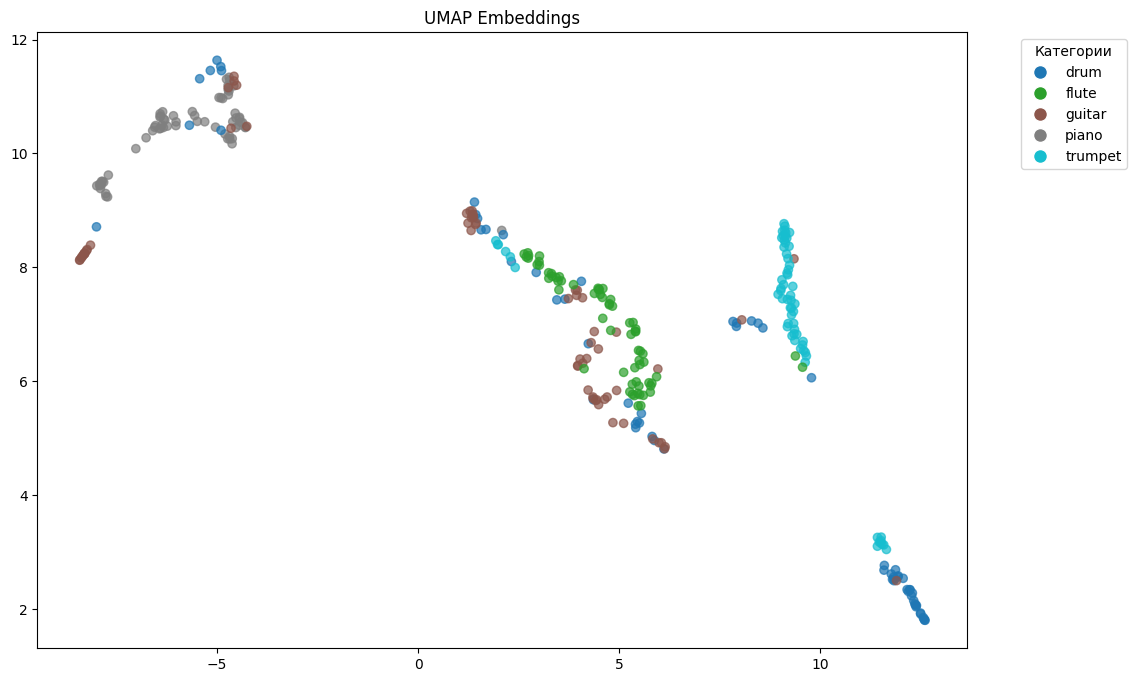

In [86]:
features = model.extract_features(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()

umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.05, random_state=None)
reduced_embeddings = umap_reducer.fit_transform(features)

plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                           c=Y_encoded, cmap='tab10', alpha=0.7)

legend_items = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter_plot.cmap(scatter_plot.norm(index)),
           markersize=10, label=class_name)
    for index, class_name in enumerate(label_encoder.classes_)
]
plt.legend(handles=legend_items, title="Категории", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Embeddings")
plt.show()

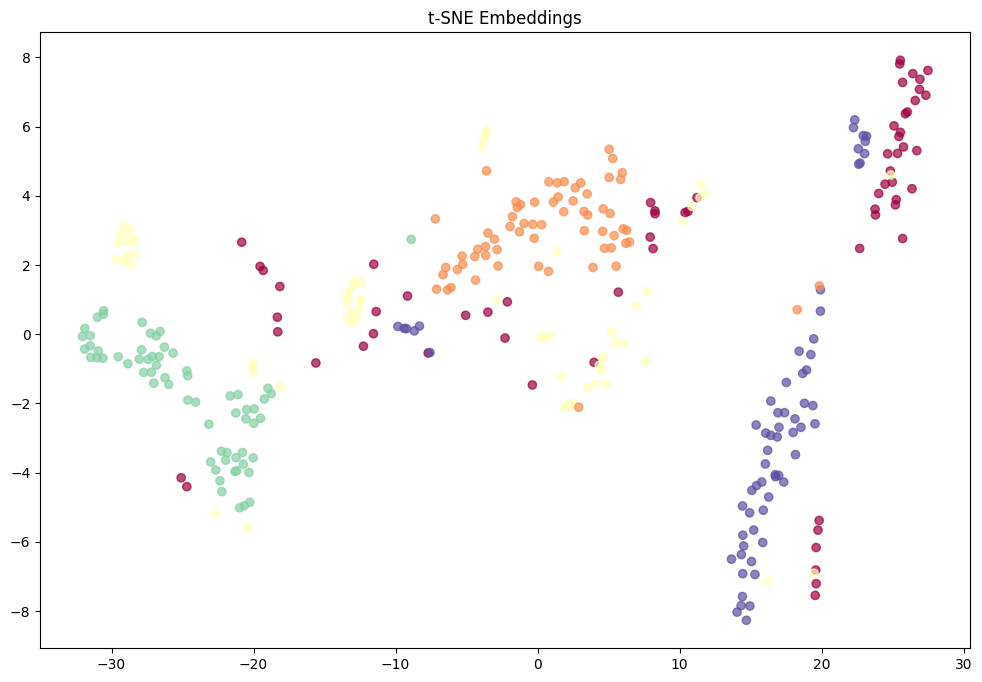

In [87]:
features = model.extract_features(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
embedding_tsne = tsne.fit_transform(features)

plt.figure(figsize=(12, 8))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=Y_encoded, cmap='Spectral', alpha=0.7)
plt.title("t-SNE Embeddings")
plt.show()

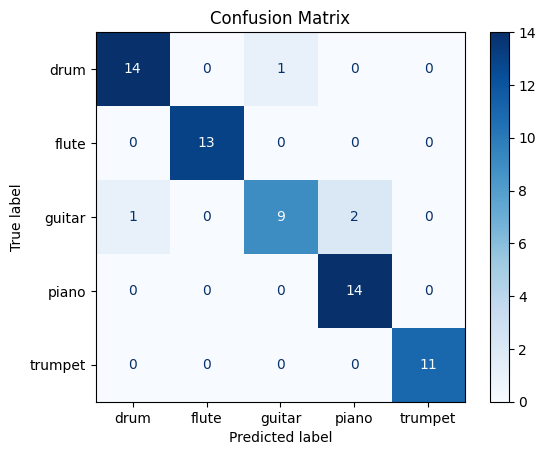

In [88]:
Y_true, Y_pred, _, _ = evaluate_model(model, test_loader, criterion, return_labels=True)
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()